# ODFM TX

In [2357]:

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal as signal
from scipy.signal import correlate, correlation_lags, fftconvolve

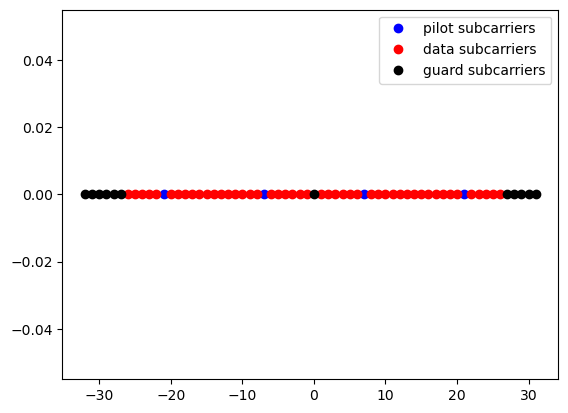

In [2358]:
# Basic OFDM and system parameters
FFT = 64  # Number of FFT points
OFDM_size = 80  # Total size including cyclic prefix
data_size = 48  # Number of data subcarriers
mess_length = 560
CP = 16  # Cyclic prefix length
pilotValue = 2* (1.4142 + 1.4142j)  # Pilot symbol

# Default text to encode if none is given
text_message = 'I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.'

# Subcarrier allocations
allCarriers = np.arange(-FFT//2, FFT//2) 
pilotCarriers = np.array([-21,-7,7,21])  # Pilot carriers
dataCarriers = np.array([-26,-25,-24,-23,-22,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,
                              -9,-8,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,
                              18,19,20,22,23,24,25,26])
reserved = np.concatenate((dataCarriers, pilotCarriers))
guardCarriers = np.array([sc for sc in allCarriers if sc not in reserved])

# Carrier visualization
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot subcarriers')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data subcarriers')
plt.plot(guardCarriers, np.zeros_like(guardCarriers), 'ko', label='guard subcarriers')
plt.legend()

In [2359]:
def text2bits(message):
    # Convert text message to list of bits (ASCII 8-bit binary per character)
    return [int(bit) for char in message for bit in format(ord(char), '07b')]
    

In [2360]:
def lut(data, inputVec, outputVec):
    # Lookup table for modulation mapping
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        for k in range(len(data)):
            if abs(data[k] - inputVec[i]) < eps:
                output[k] = outputVec[i]
    return output
    

In [2361]:
def binary2mary(data, M):
    # Convert binary data to M-ary symbols
    log2M = round(math.log2(M))
    if len(data) % log2M != 0:
        raise ValueError("Input to binary2mary must be divisible by log2(M).")
    binvalues = 2 ** np.arange(log2M - 1, -1, -1)
    reshaped_data = np.reshape(data, (-1, log2M))
    return reshaped_data.dot(binvalues)
    

In [2362]:
def generate_QPSK_signal(message):
    # Generate modulated data symbols using QPSK
    A = math.sqrt(9/2)  # Amplitude scaling
    data_sequence = text2bits(message)  # Convert message to bits
    # data_bits = np.tile(data_sequence, 20)  # Repeat bits to fill frame
    data_sequence = np.tile(data_sequence,10)
    data = binary2mary(data_sequence, 4)  # Convert to 4-ary symbols (QPSK)

    # QPSK mapping
    inputVec = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]

    # Map symbols to complex IQ samples
    xI = lut(data, inputVec, outputVecI).reshape((1, len(data)))
    xQ = lut(data, inputVec, outputVecQ).reshape((1, len(data)))
    qpsk_IQ = (xI.flatten() + 1j * xQ.flatten()).astype(np.complex64)
    return qpsk_IQ


In [2363]:
def generate_ofdm_signal(data):
    # Generate OFDM symbols from data
    result = []
    for i in range(len(data) // data_size):
        payload = data[i * data_size: (i + 1) * data_size]
        symbol = np.zeros(FFT, dtype=complex)

        # Insert pilot symbols
        symbol[pilotCarriers] = pilotValue
       
        # Insert data symbols
        symbol[dataCarriers] = payload

        # IFFT and add cyclic prefix
        ofdm_time = np.fft.ifft(symbol,n=FFT) #np.fft.ifft(np.fft.ifftshift(symbol), n=self.FFT)
        cp = ofdm_time[-CP:]
        result.extend(np.hstack([cp, ofdm_time]))

    return np.array(result)


In [2364]:
def raised_cosine_taper(L):
    # L = taper length in samples (e.g., 4)
    n = np.arange(L, dtype=float)
    return 0.5 * (1 - np.cos(np.pi * n / (L - 1)))
    

In [2365]:
def window_ofdm_stream(sym_cp, cp_len, win_len=4):
    """
    symbols_td: array of shape [num_syms, Nfft] (time-domain IFFT outputs)
    Returns a 1-D stream with CP, short raised-cosine windowing, and proper overlap-add.
    """
    if win_len is None or win_len <= 0:
        return sym_cp
    assert win_len <= cp_len, "win_len must be ≤ CP."
    w = np.ones_like(sym_cp, dtype=float)
    taper = raised_cosine_taper(win_len)
    w[:win_len]  *= taper          # fade-in (within CP)
    w[-win_len:] *= taper[::-1]    # fade-out (end of symbol)
    return sym_cp * w
    

In [2366]:
def generate_ofdm_signal_window(data, win_len=4):
    # Generate OFDM symbols from data
    result = []
    for i in range(len(data) // data_size):
        payload = data[i * data_size: (i + 1) * data_size]
        symbol = np.zeros(FFT, dtype=complex)

        # Insert pilot symbols
        symbol[pilotCarriers] = pilotValue
        # Insert data symbols
        symbol[dataCarriers] = payload

        # IFFT and add cyclic prefix
        ofdm_time = np.fft.ifft(symbol, n=FFT)
        cp = ofdm_time[-CP:]
        sym_cp = np.hstack([cp, ofdm_time])

        # >>> apply windowing here <<<
        sym_cp = window_ofdm_stream(sym_cp, cp_len=CP, win_len=win_len)

        result.extend(sym_cp)

    return np.array(result)
    

In [2367]:
def generate_ltf():
    mat = scipy.io.loadmat('preamble.mat')
    ltf = mat['stf'].flatten()  # complex array
    return np.tile(ltf, 1)      # repeat 2 times

# def generate_ltf():
#     # Load and repeat training sequence from HTSTF.mat file
#     mat = scipy.io.loadmat('HTSTF.mat')
#     stf = mat['stf'].flatten()
#     return np.tile(stf, 2)

In [2368]:
def generate_ofdm_packet():
    # Combine all steps to create a complete ofdm packet
    qpsk = generate_QPSK_signal(text_message)
    # ofdm = generate_ofdm_signal_window(qpsk)
    ofdm = generate_ofdm_signal(qpsk)
    # preamble    = np.tile([1, 1, 0, 0], 16)
    preamble = generate_ltf()
    return np.concatenate([0.3*preamble, ofdm])
    

Length of tx_signal: 5760
Length of preamble: 160


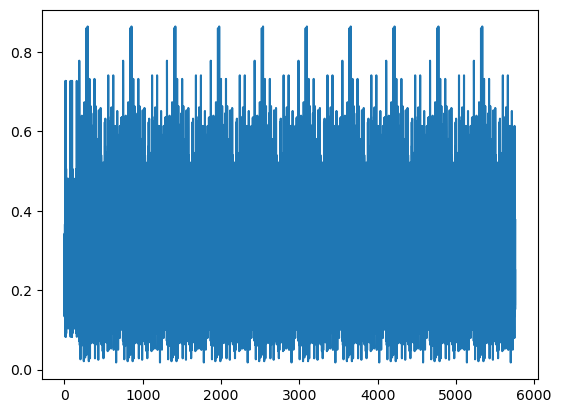

In [2369]:
tx_signal = generate_ofdm_packet()
print('Length of tx_signal:',len(tx_signal))
print('Length of preamble:',len(generate_ltf()))
plt.plot(abs(tx_signal))
plt.show()

# OFDM Receiver Below

In [2370]:
# Load complex signal
rx_signal = np.fromfile("5dB_rx_output.dat", dtype=np.complex64)
# rx_signal = generate_ofdm_packet()
# rng = np.random.default_rng(seed=42)
# sigma = 0.1
# noise = sigma * rng.standard_normal(rx_signal.shape) 
# rx_signal = rx_signal + noise

In [2371]:
def cross_correlation_max(rx0, preamble, normalized=False, preamble_scale=0.00005):
    """
    Cross-correlate rx0 with a known preamble and plot:
      - RX real/imag with the detected preamble overlaid at the detected start index
      - Correlation magnitude (or NCC) vs. sample index (no negative lags)
    """

    rx0 = np.asarray(rx0, dtype=np.complex64)
    preamble = np.asarray(preamble, dtype=np.complex64)

    # --- Complex matched filter correlation ---
    kernel = np.conj(preamble[::-1])
    xcorr_out = signal.fftconvolve(rx0, kernel, mode='valid')  # valid mode → only non-negative shifts

    if normalized:
        tpl_energy = np.sqrt(np.sum(np.abs(preamble)**2)) + 1e-12
        win_energy = np.sqrt(
            signal.convolve(np.abs(rx0)**2,
                            np.ones(len(preamble), dtype=np.float32),
                            mode='valid')
        ) + 1e-12
        metric = np.abs(xcorr_out) / (tpl_energy * win_energy)
        ylabel = "NCC value"
        title_suffix = " (Normalized)"
    else:
        metric = np.abs(xcorr_out)
        ylabel = "|Cross-correlation|"
        title_suffix = ""

    # Pick peak

    preamble_start = int(np.argmax(metric))

    print(f"Detected preamble at sample index {preamble_start}")

    # --- Plot ---
    fig, axes = plt.subplots(2, 1, figsize=(11, 6))

    # Top: RX signal with overlaid preamble
    axes[0].plot(np.real(rx0), label='Real RX Signal')
    axes[0].plot(np.imag(rx0), label='Imag RX Signal')
    overlay_x = np.arange(preamble_start, preamble_start + len(preamble))
    overlay_p = preamble * preamble_scale
    axes[0].plot(overlay_x, np.real(overlay_p), label='Preamble (real, scaled)')
    axes[0].plot(overlay_x, np.imag(overlay_p), label='Preamble (imag, scaled)', alpha=0.7)
    axes[0].set_title("Received Signal with Detected Preamble Overlay")
    axes[0].legend(loc='upper right')

    # Bottom: correlation metric vs. index
    axes[1].plot(metric, label=ylabel)
    axes[1].axvline(preamble_start, linestyle='--', color='r', label=f'Detected start = {preamble_start}')
    axes[1].set_xlabel("Sample index")
    axes[1].set_ylabel(ylabel)
    axes[1].legend(loc='upper right')
    axes[1].set_title(f"Cross-Correlation{title_suffix}")

    plt.tight_layout()
    plt.show()

    return preamble_start


In [2372]:
def binvector2str(bits):
        """
        Convert a flat iterable of 0/1 to a 7-bit ASCII string (MSB first).
        Pure-Python, no NumPy required.
        """
        bits = list(bits)
        if len(bits) % 7 != 0:
            raise ValueError("Length of bit stream must be a multiple of 7.")
    
        out_chars = []
        for i in range(0, len(bits), 7):
            byte = 0
            # MSB first: positions 0..6 map to weights 64..1
            # converts the binary chunk into its integer value
            for b in bits[i:i+7]:
                byte = (byte << 1) | (1 if b else 0)
            out_chars.append(chr(byte))
        # Joins the list of characters into a single string
        rx_text = ''.join(out_chars) 
        print('Received Message:', rx_text)
        return rx_text

In [2373]:
def mary2binary(data, M):
        length = len(data) # number of values in data
        log2M = round(np.log2(M)) # integer number of bits per data value
        format_string = '0' + str(log2M) + 'b'
        binarydata = np.zeros((1,length*log2M))
        count = 0
        for each in data:
            binval = format(int(each), format_string)
            for i in range(log2M):
                binarydata[0][count+i] = int(binval[i])
            count = count + log2M
        return binarydata

In [2374]:
def findClosestComplex(r_hat, outputVec):
        # outputVec is a 4-length vector for QPSK, would be M for M-QAM or M-PSK.
        # This checks, one symbol sample at a time,  which complex symbol value
        # is closest in the complex plane.
        data_out = [np.argmin(np.abs(r-outputVec)) for r in r_hat]
        return data_out

In [2375]:
def constellation_plot(signal):
    plt.figure(figsize=(5,5))
    ax = plt.gca() 
    ax.set_aspect(1.0)
    plt.plot(np.real(signal), np.imag(signal),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.title('Constellation Diagram')
    plt.grid('on')
    plt.tight_layout()


In [2376]:
def Channel_Estimation(signal):
    eps = 1e-12
    pilots = signal[pilotCarriers]
    H_at_pilots = pilots / (pilotValue + eps)

    H_abs   = scipy.interpolate.interp1d(pilotCarriers, np.abs(H_at_pilots),
                                         kind='nearest', fill_value='extrapolate')(allCarriers)
    H_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(H_at_pilots),
                                         kind='nearest', fill_value='extrapolate')(allCarriers)
    H_estimate = H_abs * np.exp(1j * H_phase)
    H_full = np.zeros_like(signal, dtype=complex)
    H_full[allCarriers] = H_estimate
    return H_full

In [2377]:
def Equalization(OFDM_demod, H_est):
    return OFDM_demod / H_est

In [2378]:
def matched_filter_demodulation(rx_signal):
    outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
    preamble = generate_ltf()
    preamble_start = cross_correlation_max(rx_signal,preamble)
    # time_signal = rx_signal[preamble_start: preamble_start + mess_length]
    # X_LTF = load_X_LTF_from_preamble('preamble.mat')
    # H0    = estimate_H0_from_rx_ltf(time_signal, X_LTF, num_ltf=2)

    data_start = preamble_start + len(preamble)
    data_signal = rx_signal[data_start: data_start + mess_length]
    
    for i in range(len(data_signal)//(OFDM_size)):
        data_cp = data_signal[i*(OFDM_size):(i+1)*(OFDM_size)]
        data_without_cp = data_cp[CP:]
        
        # Generate frequency domain signal
        OFDM_freq = np.fft.fft(data_without_cp,n=FFT)
        
        # H_est = Channel_Estimation_With_LFT(OFDM_freq, H0 = H0) # estimate the channel
        H_est = Channel_Estimation2(OFDM_freq) # estimate the channel
        
        OFDM_est = Equalization(OFDM_freq, H_est) # sub-carrier equalization
        
        OFDM_data = OFDM_est[dataCarriers] # extract the data signal
        if i == 0:
            OFDM_swap =  OFDM_data
        else:
            OFDM_signal = np.concatenate((OFDM_swap,  OFDM_data))
            OFDM_swap = OFDM_signal
            
    constellation_plot(OFDM_signal)
    mary_out  = findClosestComplex(OFDM_signal, outputVec)
    data_bits  = mary2binary(mary_out, 4)[0]
    return data_bits

Detected preamble at sample index 0


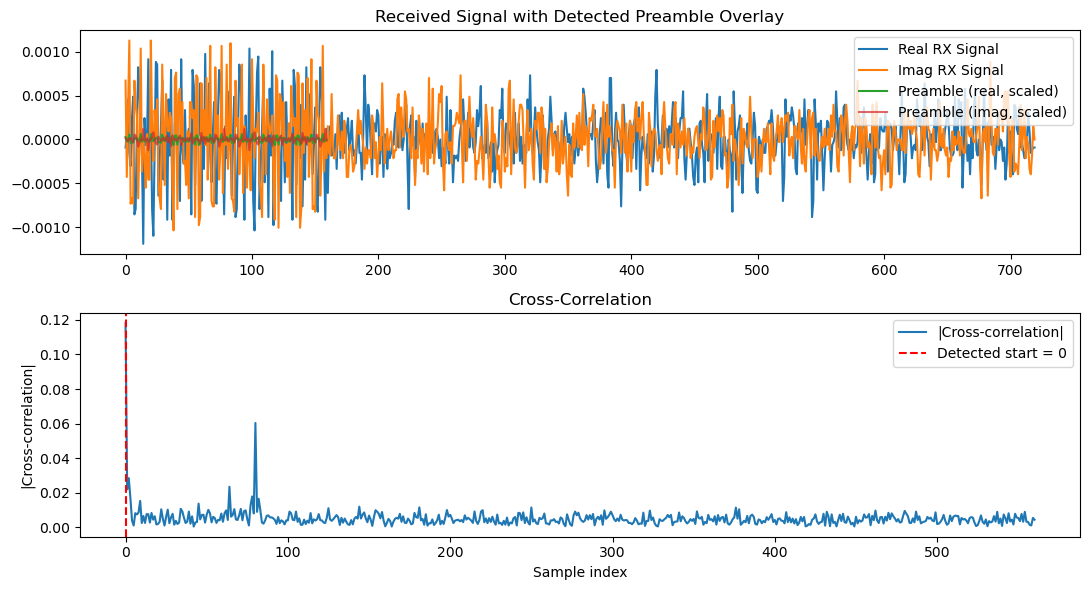

Received Message: Pseudonymetr}8"AihA.`specurum shar{	LC2Otocol fnz #gkperative coexistelce b/n wirelesc Systems.


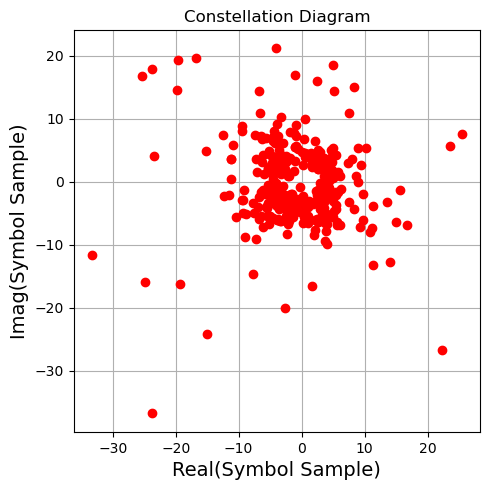

In [2379]:
rx_signal = np.fromfile("5dB_rx_output.dat", dtype=np.complex64)
rx_bits = matched_filter_demodulation(rx_signal)
rx_message = binvector2str(rx_bits)